<a href="https://colab.research.google.com/github/csaundersshultz/github_training/blob/main/SO2_segmentation_satellite_view.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#SO2 segmentation this one will be focused on the satellite view case
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime
import math
import time

from skimage.segmentation import find_boundaries
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_bilateral
from skimage.exposure import rescale_intensity
from skimage.measure import find_contours, approximate_polygon
from skimage.draw import polygon

import albumentations as A

import tensorflow as tf
layers = tf.keras.layers
Model = tf.keras.Model
tf.random.set_seed(42)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU, SparseCategoricalAccuracy
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle as sklearn_shuffle
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [ ]:
#read in list of files, plot quick statistics and split into train/validation/test
#set up generator to create masks and open files
#initialize pre_fetching with generator and tf.data.Dataset
#set up model architecture to accept 352x352 images
#compile model, set up metrics and optimizer etc
#train model
#visualize training results

In [3]:
!git clone https://github.com/csaundersshultz/github_training

Cloning into 'github_training'...
remote: Enumerating objects: 534, done.
remote: Total 534 (delta 0), reused 0 (delta 0), pack-reused 534
Receiving objects: 100% (534/534), 1.87 GiB | 25.28 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (537/537), done.


In [4]:
data_list = pd.read_csv("github_training/final_500_training.csv")
#print(data_list.head())

fn_train, fn_valtest, verts_train, verts_valtest = train_test_split(data_list.file, data_list.vertices, test_size=0.3, random_state=42)
fn_val, fn_test, verts_val, verts_test = train_test_split(fn_valtest, verts_valtest, test_size=0.5, random_state=42)

for dataset in (verts_train, verts_val, verts_test):
    print( f"{len(dataset.loc[dataset=='[]'])} / {len(dataset)}" )
#later, remove files in training/ which are not in the data_list. and find the one file not removed somehow. 

167 / 350
38 / 75
31 / 75


In [ ]:
def add_border(mask, bordersize=3):
    if bordersize==0:
        return mask
    c = bordersize%2+1 #1 or 2, sets up alternating whether or not corners are counted, creates the most rounded shape
    boundary = find_boundaries(mask, connectivity=c, mode='outer', background=0)
    bounds_and_mask = np.logical_or(boundary, mask)
    if bordersize!=0:#continue until bordersize is less than 1
        extended_border = add_border(bounds_and_mask, bordersize=bordersize-1)
        extended_border = (extended_border>0).astype('int')
        bordered_mask = extended_border + mask
        return bordered_mask #background=0, adjacents=1, hotspot=2
    else: 
        final_mask = bounds_and_mask+mask 
        return final_mask

def build_mask(vertices, shape=(352,352), bordersize=0):
    """
    Takes a list of polygons with vertices. example:
        [  [(1, 1), (1, 5), (5, 5), (5, 1)], #polygon1
         [(10, 10), (10, 15), (15, 15), (15, 10)] ]  #polygon 2
    """
    mask = np.zeros(shape, dtype=bool)
    for polygon_vertices in vertices:
        rr, cc = polygon(np.array(polygon_vertices)[:, 0], np.array(polygon_vertices)[:, 1], shape=shape)
        mask[cc, rr] = True
    
    if bordersize>0:
        mask = add_border(mask)
    return mask

def get_weights(mask):
    weights = np.zeros(mask.shape)
    weights[np.where(mask==0)] = 0.005 #background
    weights[np.where(mask==1)] = 1 #adjacent pixels
    weights[np.where(mask==2)] = 1 #active pixels
    return weights

def normalize_image_batch(images):
    """
    Normalize the pixel values of a batch of images to the range [0, 1].
    Args:
        images: A numpy array of shape (num_images, height, width, num_channels).
    Returns:
        A numpy array of shape (num_images, height, width, num_channels) with pixel values in the range [0, 1].
    """
    num_images, height, width, num_channels = images.shape
    for i in range(num_images):
        for j in range(num_channels):
            img = images[i, :, :, j]
            if np.min(img) != 0 or np.max(img) != 1:
                img = rescale_intensity(img, in_range=(np.nanmin(img), np.nanmax(img)), out_range=(0, 1))
                img = np.nan_to_num(img, nan=0.0)
                images[i, :, :, j] = img
    return images

class DataGenerator(tf.keras.utils.Sequence): #subclass the Sequence object #subclass or extend?
    def __init__(self, x, y, #inputs to generator
                 batch_size=2, normalize=True, #arguments used for all datasets in same model run
                 augmentation=False, shuffle=False, weights=False, border=0): #arguments used for training only
        self.batch_size = batch_size #size of the batch
        self.shuffle=shuffle
        self.augmentation=augmentation
        self.weights=weights
        self.x = x
        self.y = y
        self.border = border
        
        if self.augmentation: #initialize random augmenter function
            self.augmenter = A.Compose( [A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomRotate90(p=1)] ) #8 equally likely possibilities
        print("Generator initiated with {} sample".format(len(self.y)))

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))   #last batch is smaller than others I think?
        #return int(np.floor(len(self.x) / float(self.batch_size)))  #all same size batches, leaves out last smaller batch

    def __getitem__(self, idx): #returns an entire batch when called, index is the batch number starting from 0
        batch_fn = self.x[ idx*self.batch_size : (idx+1)*self.batch_size ] #list of granules
        
        #open list of files
        batch_data = np.array([ np.load(fn)[...,4] for fn in batch_fn ]) #limit to just slant column density
        X = np.expand_dims(batch_data, axis=-1) #batch_data.reshape((self.batch_size, 352, 352, 1))
        X = normalize_image_batch(X)
        plt.imshow(X[0,:,:,0])
        global failed_layer 
        failed_layer = X[0,:,:,0]
        plt.colorbar()

        assert not np.any(np.isnan(X))
        #print(X.shape)
        
        #BUILD MASKS
        vertices = self.y[ idx*self.batch_size : (idx+1)*self.batch_size ] #ready to return
        masks = np.array([build_mask(eval(verts), bordersize=self.border) for verts in vertices])
        masks = np.expand_dims(masks, axis=-1)
        #print(masks.shape)
    
        #AUGMENTATION
        if self.augmentation: #augment each image/mask combo 
            augmented_all = [self.augmenter(image=im, mask=ma) for im,ma in zip(X, masks)]
            X =      np.array( [augmented["image"] for augmented in augmented_all])
            masks =  np.array( [augmented["mask"] for augmented in augmented_all])
        
        #WEIGHTS or not
        if self.weights:
            weights = np.array([get_weights(mask) for mask in masks])
            return X, masks, weights
        else: 
            return X, masks
    
    def on_epoch_end(self): #shuffles the dataframe at the end of each epoch
        if self.shuffle == True:
            #reset all the main things, this should probably be done in fewer lines of code
            self.df = sklearn_shuffle(self.df, random_state=42) #Using a random_state still shuffles differently every epoch, I checked
            self.x = self.df[self.x_col].tolist() #list of ALL granules
            self.y = self.df[self.y_col].astype(int).to_numpy() #list of ALL vertices lists
            
#old train/test split
params_list = ['GEOLOCATION/latitude', 'GEOLOCATION/longitude', 'INPUT_DATA/cloud_fraction_crb',
                  'OUTPUT_PRODUCTS/cloud_fraction_intensity_weighted',
                  'OUTPUT_PRODUCTS/sulfurdioxide_slant_column_corrected', 'OUTPUT_PRODUCTS/sulfurdioxide_total_vertical_column', 
                  'OUTPUT_PRODUCTS/sulfurdioxide_total_vertical_column_1km', 'OUTPUT_PRODUCTS/sulfurdioxide_total_vertical_column_7km', 
                  'OUTPUT_PRODUCTS/sulfurdioxide_total_vertical_column_15km']
WEIGHTS = False
BORDER=0
NORMALIZE=True
my_generator = DataGenerator(fn_train, verts_train, augmentation=False, shuffle=True, normalize=NORMALIZE)
val_generator = DataGenerator(fn_val, verts_val)
test_generator = DataGenerator(fn_test, verts_test)

generator_output_signature = (tf.TensorSpec(shape=(None, 352, 352, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, 352, 352, 1), dtype=tf.float32) )
train_dataset = tf.data.Dataset.from_generator(lambda: my_generator, output_signature = generator_output_signature )
val_dataset  = tf.data.Dataset.from_generator(lambda: val_generator, output_signature = generator_output_signature)
test_dataset   = tf.data.Dataset.from_generator(lambda: test_generator, output_signature = generator_output_signature)


# apply prefetching and caching to the datasets
prefetch_size = -1 #AUTOTUNE
prefetch_dataset = train_dataset.prefetch(prefetch_size) #PREFETCHING IMPLEMENTED
val_prefetch = val_dataset.prefetch(prefetch_size)

Generator initiated with 350 sample
Generator initiated with 75 sample
Generator initiated with 75 sample


2023-04-18 10:22:11.985463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#U_NET ARCHITECTURE 
#I removed dropout layers for now. 
#Normalization still isn't implemented. Not sure how best to do this.
#do need to add a 3d convolution in here maybe as a first convolve block?

#this time do it better, create functions to minimize code redundancy
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    #p = layers.Dropout(0.3)(p)
    return f, p
def upsample_block(x, conv_features, n_filters):
    # upsample
    #x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    #Get rid of the conv2dtranspose and replace with just upsampling
    #using resizing gets rid of 20k params too
    #print(x.shape)
    width_height = 2*x.shape[1]
    x = tf.image.resize(x, [width_height, width_height] , method='nearest')
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    #x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model(INPUTS=1):
    # inputs
    inputs = layers.Input(shape=(352,352,INPUTS))
    #normalize layer, prior to any convolving
    #normalized_inputs = layers.BatchNormalization()(inputs) #I REALLY HOPE THIS WORKS!!!!!!
    # encoder: contracting path - downsample
    
    #extra downsample
    f0,p0 = downsample_block(inputs,8)
    
    # 1 - downsample
    f1, p1 = downsample_block(p0, 16)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 24)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 32)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 40)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 48)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 40)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 32)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 24)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 16)
    
    #10 extra upsample block, optional
    u10 = upsample_block(u9, f0, 8)
    
    # OUTPUTS
    if BORDER==0: 
        num_outputs = 2
    else: num_outputs = 3
    outputs = layers.Conv2D(filters=num_outputs, kernel_size=1, padding="same", activation = "softmax")(u10) #
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
model = build_unet_model(INPUTS=1)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 352, 352, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 352, 352, 8)  80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 352, 352, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 176, 176, 8)  0           ['conv2d_1[0][0]']           

In [ ]:
#Metrics from thermal project
#compile the model, see tutorial for what everything here is
class UpdatedMeanIoU(MeanIoU):
    def __init__(self,
                   y_true=None,
                   y_pred=None,
                   num_classes=None,
                   name=None,
                   dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)
def class_from_mask(mask):
    if BORDER==0:
        if tf.reduce_max(mask)==1:
            return 1
        else: return 0
    else: #else 3 classes with borders
        if tf.reduce_max(mask) == 2: #image is active,
            return 1
        else: return 0
    
def image_acc(y_true, y_pred):
    #get image classifications for both true and predicted masks
    pred_masks = tf.argmax(y_pred, axis=3) #convert probabilistic predictions to mask
    y_true = y_true.numpy()
    y_pred = pred_masks.numpy()
    true_class = [class_from_mask(mask) for mask in y_true]
    pred_class = [class_from_mask(mask) for mask in y_pred]
    #now evaluate accuracy 
    acc = accuracy_score(true_class, pred_class)
    return acc

def FP(y_true, y_pred):
    pred_masks = tf.argmax(y_pred, axis=3) #convert probabilistic predictions to mask
    y_true = y_true.numpy()
    y_pred = pred_masks.numpy()
    true_class = [class_from_mask(mask) for mask in y_true]
    pred_class = [class_from_mask(mask) for mask in y_pred]
    return 0
    
def FN(y_true, y_pred):
    pass
    
def image_f1(y_true, y_pred):
    #get image classifications for both true and predicted masks
    pred_masks = tf.argmax(y_pred, axis=3)
    y_true = y_true.numpy()
    y_pred = pred_masks.numpy()
    true_class = [class_from_mask(mask) for mask in y_true]
    pred_class = [class_from_mask(mask) for mask in y_pred]
    if 1 in pred_class: #if no active predictions are made the f1 score is undefined
        f1 = f1_score(true_class, pred_class)
        return f1
    else: return 0

metrics = [SparseCategoricalAccuracy(), UpdatedMeanIoU(num_classes=3, name='IoU'), image_acc, image_f1]
metrics2 = [SparseCategoricalAccuracy(), image_acc]

model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=metrics2, run_eagerly=True)

In [ ]:
start_time = time.time()

history = model.fit(prefetch_dataset, validation_data = val_prefetch, epochs=10, verbose=1) #prefetching, makes it ~10 times faster!

training_time = time.time() - start_time
print(f"Total training time is {training_time//60}m : {training_time%60}s")

Epoch 1/10
    159/Unknown - 129s 804ms/step - loss: 0.0493 - sparse_categorical_accuracy: 0.9942 - image_acc: 0.4780

In [ ]:
#learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 200:
        return lr
    else:
        return lr * math.exp(-0.05)
#def metrics_callback(epoch, lr):
    
callback = LearningRateScheduler(scheduler)

In [ ]:
print(np.max(failed_layer))
plt.imshow(fbuygr)

NameError: name 'np' is not defined

In [ ]:
#test prediction
fn ="training/Western Aleutians/Western_Aleutians__SECTOR_view__20220605T235110.nc"

test_params = params
img = open_h5file(fn, params=params)
#img = tf.image.resize_with_crop_or_pad(image=img, target_height=256, target_width=256)
img = tf.image.resize(images=img, size=[256,256], method='gaussian')

prediction = model.predict(np.expand_dims(img, axis=0))
active_prob = prediction[0,:,:,2]
pred = tf.argmax(prediction[0,:,:,:], axis=2)

fig, axs = plt.subplots(ncols=2, figsize=(24,10))
axs[0].imshow(img[:,:,0], interpolation=None)
prob = axs[1].imshow(active_prob, interpolation=None)
plt.colorbar(prob, ax=axs[1])
#print(active_prob)
plt.xticks([])
plt.yticks([])



1/1 [==============================] - 0s 68ms/step


IndexError: index 2 is out of bounds for axis 3 with size 2

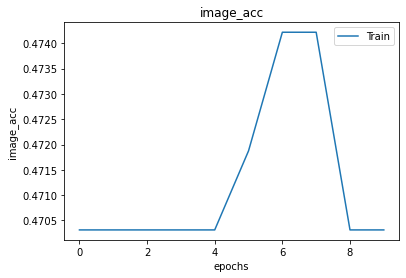

In [ ]:
metric='image_acc'

plt.plot(history.history[metric], label="Train")
#plt.plot(history.history[f"val_{metric}"], label="Validation")
plt.title(metric)
plt.xlabel("epochs")
plt.ylabel(metric)
plt.legend()

In [ ]:
print(img.shape)